## ===================classify names with char rnn=======================

In [1]:
import numpy as np
import pandas as pd
import json
import re
import torch

In [2]:
from io import open
import glob
import os
import string
import unicodedata

### PREPARING THE DATA

In [3]:
def findFiles(path):
    return glob.glob(path)


In [4]:
print(findFiles('./classify names with char rnn/data/names/*.txt'))

['./classify names with char rnn/data/names\\Arabic.txt', './classify names with char rnn/data/names\\Chinese.txt', './classify names with char rnn/data/names\\Czech.txt', './classify names with char rnn/data/names\\Dutch.txt', './classify names with char rnn/data/names\\English.txt', './classify names with char rnn/data/names\\French.txt', './classify names with char rnn/data/names\\German.txt', './classify names with char rnn/data/names\\Greek.txt', './classify names with char rnn/data/names\\Irish.txt', './classify names with char rnn/data/names\\Italian.txt', './classify names with char rnn/data/names\\Japanese.txt', './classify names with char rnn/data/names\\Korean.txt', './classify names with char rnn/data/names\\Polish.txt', './classify names with char rnn/data/names\\Portuguese.txt', './classify names with char rnn/data/names\\Russian.txt', './classify names with char rnn/data/names\\Scottish.txt', './classify names with char rnn/data/names\\Spanish.txt', './classify names wit

In [5]:
all_letters = string.ascii_letters + " ,.;'"
n_letters = len(all_letters)

In [6]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [7]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [8]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [9]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [10]:
for filename in findFiles('./classify names with char rnn/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    category_lines[category] = readLines(filename)

n_categories = len(all_categories)

In [11]:
category_lines['English'][:4]

['Abbas', 'Abbey', 'Abbott', 'Abdi']

In [12]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [13]:
# turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [14]:
# Turn a line into a <line_length x 1 x n_letters>, or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i in range(len(line)):
        tensor[i][0] = letterToTensor(line[i])
    return tensor
        

In [15]:
letterToTensor('f')

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [16]:
lineToTensor('lsk').size()

torch.Size([3, 1, 57])

### CREATING THE NETWORK

In [17]:
import torch.nn as nn

In [31]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden):
        combine = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combine)
        output = self.i2o(combine)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [32]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [33]:
input_ = letterToTensor('L')
hidden = torch.zeros(1, n_hidden)
output, hidden = rnn(input_, hidden)

In [36]:
print(output)

tensor([[-2.9409, -2.8248, -2.8968, -2.7698, -2.9427, -2.8091, -2.8301, -2.9822,
         -2.8413, -2.9813, -2.9368, -2.8935, -2.9377, -2.9108, -2.7839, -2.9612,
         -2.9735, -2.8522]], grad_fn=<LogSoftmaxBackward>)


In [37]:
input_2 = lineToTensor('Llbert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_2[0], hidden)
print(output)

tensor([[-2.9409, -2.8248, -2.8968, -2.7698, -2.9427, -2.8091, -2.8301, -2.9822,
         -2.8413, -2.9813, -2.9368, -2.8935, -2.9377, -2.9108, -2.7839, -2.9612,
         -2.9735, -2.8522]], grad_fn=<LogSoftmaxBackward>)


In [38]:
input_.size()

torch.Size([1, 57])

In [39]:
input_2.size()

torch.Size([6, 1, 57])

### TRAINING

### training prepare

In [42]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [43]:
categoryFromOutput(output)

('Dutch', 3)

In [4]:
import random

In [45]:
def randomChoise(l):
    return l[random.randint(0, len(l) - 1)]

In [48]:
def randomTraingExample():
    category = randomChoise(all_categories)
    line = randomChoise(category_lines[category])
    cate_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    
    return category, line, cate_tensor, line_tensor

In [53]:
torch.tensor([all_categories.index('English')], dtype=torch.long)

tensor([4])

In [50]:
for i in range(5):
    cate, line, cate_tensor, line_tensor = randomTraingExample()
    print('category=' + cate + ', line=' + line)

category=French, line=Leblanc
category=Portuguese, line=Araujo
category=Dutch, line=Reinders
category=Japanese, line=Takahashi
category=Czech, line=Wood


### training the network

In [51]:
criterion = nn.NLLLoss()

In [52]:
learning_rate = 0.005

In [54]:
def train(cate_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        input_ = line_tensor[i]
        output, hidden = rnn(input_, hidden)
    
    loss = criterion(output, cate_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

In [35]:
import math
import time

In [55]:
n_iters = 60000
plot_every = 1000
print_every = 2000

In [56]:
current_loss = 0
all_loss = []

In [72]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = s // 60
    s -= m * 60
    return '%dm %ds' %(m, s)

In [68]:
start = time.time()

for i in range(1, n_iters+1):
    category, line, cate_tensor, line_tensor = randomTraingExample()   
    output, loss = train(cate_tensor, line_tensor)
    current_loss += loss
    
    if i % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '√' if guess == category else '× {}'.format(category) 
        print('{} {}% ({}) {} {} {} {}'.format(i, i / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    if i % plot_every == 0:
        all_loss.append(current_loss / plot_every)
        current_loss = 0
        

2000 3.3333333333333335% (0m 2s) 2.8486738204956055 Proulx Spanish × French
4000 6.666666666666667% (0m 5s) 1.5743513107299805 Bustillo Italian × Spanish
6000 10.0% (0m 7s) 3.1842269897460938 Simonis Greek × Dutch
8000 13.333333333333334% (0m 10s) 0.5707998275756836 Byon Korean √
10000 16.666666666666664% (0m 12s) 0.6791834831237793 Adamczyk Polish √
12000 20.0% (0m 15s) 0.5689816474914551 Khouri Arabic √
14000 23.333333333333332% (0m 17s) 0.27594470977783203 Lillis Greek √
16000 26.666666666666668% (0m 20s) 0.3019843101501465 Qing Chinese √
18000 30.0% (0m 22s) 0.9361562728881836 Piontek Polish √
20000 33.33333333333333% (0m 25s) 1.867652177810669 Tillett Scottish × English
22000 36.666666666666664% (0m 27s) 1.5082154273986816 Issa Arabic √
24000 40.0% (0m 30s) 0.809934139251709 Ijiri Japanese √
26000 43.333333333333336% (0m 32s) 2.533116579055786 Durrant French × English
28000 46.666666666666664% (0m 35s) 0.08265924453735352 O'Sullivan Irish √
30000 50.0% (0m 37s) 0.00503349304199218

### Plotting the Results

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

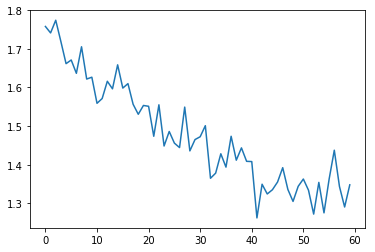

In [70]:
plt.figure()
plt.plot(all_loss)

### EVALUATING THE RESULTS

In [74]:
def evaluate(line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()
        
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        return output

In [75]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

In [76]:
for i in range(n_confusion):
    category, line, cate_tensor, line_tensor = randomTraingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    confusion[all_categories.index(category)][guess_i] += 1
    

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    

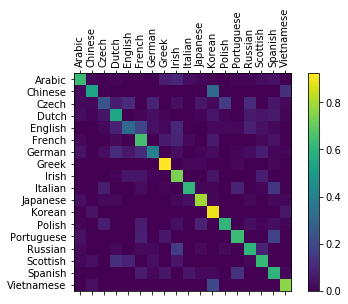

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)
cat = ax.matshow(confusion.numpy())
fig.colorbar(cat)
# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [87]:
def predict(input_line, n_predicters=3):
    print ('input:> ', input_line)
    with torch.no_grad():
        input_tensor = lineToTensor(input_line)
        output = evaluate(input_tensor)
    
    topv, top_i = output.topk(n_predicters, 1, True)
    predictions = []
    
    for i in range(n_predicters):
        val = topv[0][i].item()
        cate_id = top_i[0][i].item()
        print('({:.2f}), {}'.format(val, all_categories[cate_id]))
        predictions.append((val, all_categories[cate_id]))
    
    return predictions
    

In [88]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')

input:>  Dovesky
(-0.38), Russian
(-1.98), Czech
(-2.60), Polish
input:>  Jackson
(-0.85), Scottish
(-1.47), Russian
(-1.80), English
input:>  Satoshi
(-1.11), Arabic
(-1.53), Japanese
(-1.66), Italian


[(-1.1068410873413086, 'Arabic'),
 (-1.5286171436309814, 'Japanese'),
 (-1.660057783126831, 'Italian')]

## ===========================generating names==============================

### model

In [61]:
class RNN2(nn.Module):
    def __init__(self, category_size, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2o = nn.Linear(category_size + input_size + hidden_size, output_size)
        self.i2h = nn.Linear(category_size + input_size + hidden_size, hidden_size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input_, hidden):
        combine_1 = torch.cat((category, input_, hidden), 1)
        hidden = self.i2h(combine_1)
        output = self.i2o(combine_1)
        combine_2 = torch.cat((hidden, output), 1)
        dropout = self.dropout(combine_2)
        output_ = self.o2o(dropout)
        output_ = self.softmax(output_)
        
        return output_, hidden
        
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

### training

In [37]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [38]:
import random

In [39]:
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

In [40]:
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [41]:
def categoryToTensor(category):
    tensor = torch.zeros(1, n_categories)
    ind = all_categories.index(category)
    tensor[0][ind] = 1
    return tensor

In [42]:
def inputToTensor(input_):
    tensor = torch.zeros(len(input_), 1, n_letters)
    for i in range(len(input_)):
        ind = all_letters.find(input_[i])
        tensor[i][0][ind] = 1
    
    return tensor
        

In [43]:
def targetToTensor(line):
    letter_inds = [all_letters.find(line[i]) for i in range(1, len(line))]
    letter_inds.append(n_letters - 1)
    
    return torch.LongTensor(letter_inds)

In [44]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    cate_tensor = categoryToTensor(category)
    input_tensor = inputToTensor(line)
    target_tensor = targetToTensor(line)
    #print(cate_tensor.size(), input_tensor.size(), target_tensor.size())
    return cate_tensor, input_tensor, target_tensor

In [67]:
criterion = nn.NLLLoss()
learning_rate = 0.005

rnn = RNN2(n_categories, n_letters, 128, n_letters)

In [68]:
def train(cate_tensor, input_tensor, target_tensor):
    target_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(cate_tensor, input_tensor[i], hidden)
        
        l = criterion(output, target_tensor[i])
        loss += l
        
    loss.backward()
    
    '''
    for p in rnn.named_parameters():
        print(p[0])
        print(p[1].grad)
    '''
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_tensor.size()[0]
    

In [69]:
n_iters = 60000
plot_every = 1000
print_every = 2000

In [70]:
current_loss = 0
all_loss = []

In [74]:
start = time.time()

for i in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    current_loss += loss
    
    if i % print_every == 0:
        print('{} {:.3}% ({}) {}'.format(i, i / n_iters * 100, timeSince(start), loss))
    
    if i % plot_every == 0:
        all_loss.append(current_loss / plot_every)
        current_loss = 0



2000 3.3333333333333335% (0m 6s) 2.5307792027791343
4000 6.666666666666667% (0m 12s) 2.923072099685669
6000 10.0% (0m 19s) 2.6317022111680775
8000 13.333333333333334% (0m 25s) 3.2687627618963067
10000 16.666666666666664% (0m 31s) 2.2600662231445314
12000 20.0% (0m 39s) 2.006850814819336
14000 23.333333333333332% (0m 45s) 2.6528994820334693
16000 26.666666666666668% (0m 52s) 1.8246253728866577
18000 30.0% (0m 58s) 1.8739002227783204
20000 33.33333333333333% (1m 5s) 1.975202242533366
22000 36.666666666666664% (1m 11s) 1.4577653408050537
24000 40.0% (1m 17s) 2.160731451851981
26000 43.333333333333336% (1m 23s) 2.727476437886556
28000 46.666666666666664% (1m 29s) 2.5003886222839355
30000 50.0% (1m 35s) 1.9487213134765624
32000 53.333333333333336% (1m 41s) 2.2060232162475586
34000 56.666666666666664% (1m 47s) 2.1714682579040527
36000 60.0% (1m 54s) 2.0001659393310547
38000 63.33333333333333% (2m 0s) 1.5509767532348633
40000 66.66666666666666% (2m 6s) 1.7550228663853236
42000 70.0% (2m 12s) 

In [60]:
rnn

RNN2(
  (i2o): Linear(in_features=205, out_features=59, bias=True)
  (i2h): Linear(in_features=205, out_features=128, bias=True)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
  (dropout): Dropout(p=0.1)
  (softmax): LogSoftmax()
)

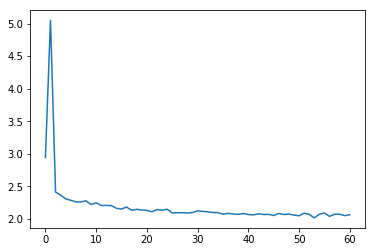

In [75]:
plt.figure()
plt.plot(all_loss)

In [87]:
max_len = 15
def sample(category, start_letter='A'):
    with torch.no_grad():
        hidden = rnn.initHidden()
        cate_tensor = categoryToTensor(category)
        input_tensor = inputToTensor(start_letter)
        
        output_name = start_letter
        
        for i in range(max_len):
            output, hidden = rnn(cate_tensor, input_tensor[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0].item()
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
                input_tensor = inputToTensor(letter)
        
        return output_name
            

In [88]:
def samples(category, start_letters='ABC'):
    output = []
    for i in start_letters:
        output.append(sample(category, i))
    print(' '.join(output))
    return output

In [90]:
samples('English')

Aleran Berger Chander


['Aleran', 'Berger', 'Chander']

In [91]:
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Romandhin Urakovin Shavakhin
Gren Echer Romer
Sala Parera Alera
Chan Han Ina


['Chan', 'Han', 'Ina']